In [33]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import xarray as xr
import os
import geopy.distance

In [34]:
base_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought'
data_dir = f'{base_dir}/data'

os.chdir(base_dir)

# Create .nc for CONUS Domain

In [8]:
# ---- Read DTR global data & NLDAS runoff data to generate domain file ---- #

# file paths
flow_dir_file = f'{data_dir}/raw/DRT_Hydrography/upscaled_global_hydrography/by_HydroSHEDS_Hydro1k/flow_direction/DRT_8th_FDR_globe.asc'
runoff_file = f'{data_dir}/processed/nldas_daily/20000101.nc'    # an arbitrary daily runoff file
new_domain_file = f'{data_dir}/processed/LRR/input/conus_nldas_grid.nc'

# Read flow direction data
with open(flow_dir_file) as f:
    # read header
    ncols = int(f.readline().split()[1])
    nrows = int(f.readline().split()[1])
    xllcorner = float(f.readline().split()[1])
    yllcorner = float(f.readline().split()[1])
    cellsize = float(f.readline().split()[1])
    nodata_value = float(f.readline().split()[1])
    # read flow direction data
    flow_dir_array = np.loadtxt(f, dtype=int)

# Read runoff data & get the border of the domain
with nc.Dataset(runoff_file) as ds_nldas:
    lon_nldas = ds_nldas.variables['lon'][:]    # index increase -> lon increase
    lat_nldas = ds_nldas.variables['lat'][:]    # index increase -> lat increase
    min_lon = lon_nldas.min()
    max_lon = lon_nldas.max()
    min_lat = lat_nldas.min()
    max_lat = lat_nldas.max()
    
# Subset flow direction data to the domain
# get the row and column indices of the domain in the flow direction array
row_start = int((yllcorner + nrows * cellsize - max_lat) / cellsize)
row_end = int((yllcorner + nrows * cellsize - min_lat) / cellsize)
col_start = int((min_lon - xllcorner) / cellsize)
col_end = int((max_lon - xllcorner) / cellsize)
# subset flow direction array using the row and column indices
flow_dir_array_domain = flow_dir_array[row_start:row_end+1, col_start:col_end+1]
flow_dir_array_domain = np.flipud(flow_dir_array_domain)    # flip the array upside down to match the latitudes, becasue the subset is from south to north (down to up)

# # Create a new netCDF file and write the subset flow direction data to it
# with nc.Dataset(new_domain_file, 'w', format='NETCDF4') as ds_domain:
#     # create dimensions
#     ds_domain.createDimension('lat', flow_dir_array_domain.shape[0])
#     ds_domain.createDimension('lon', flow_dir_array_domain.shape[1])

#     # create variables
#     lat = ds_domain.createVariable('lat', 'f4', ('lat',))
#     lon = ds_domain.createVariable('lon', 'f4', ('lon',))
#     flow_dir = ds_domain.createVariable('flow_dir', 'i4', ('lat', 'lon',))
#     # add an ID variable for each grid cell
#     id = ds_domain.createVariable('id', 'i4', ('lat', 'lon',))    # 224 * 464; lat * lon

#     # write data
#     lat[:] = lat_nldas
#     lon[:] = lon_nldas
#     flow_dir[:, :] = flow_dir_array_domain
#     id[:, :] = np.arange(1, flow_dir_array_domain.size+1).reshape(flow_dir_array_domain.shape)

#     # set attributes
#     flow_dir.long_name = 'D8 Flow direction'
#     flow_dir.missing_value = nodata_value
#     id.long_name = 'Grid ID for the CONUS NLDAS grid'


# Visualize Grid-based Flow Direction

## Entire CONUS

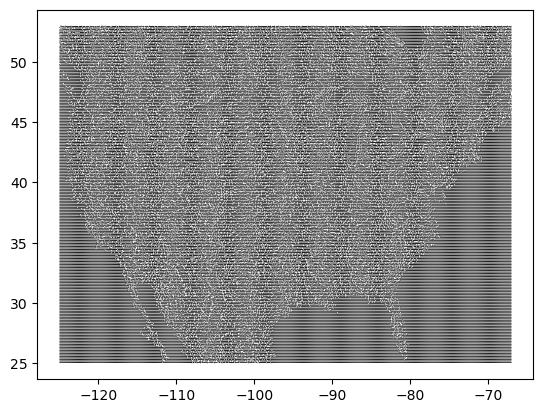

In [9]:
# ---- Visualize the flow map, using arrows ---- #

def d8_to_uv(d8_value):
    """
    Convert the D8 flow direction value to u and v components.
    The values follow the pattern (1, 2, 4, 8, 16, 32, 64, 128),
    representing the following directions (assuming north is up):
    32  64 128
    16  x   1
    8   4   2

    :param d8_value: D8 flow direction value [int]
    """
    
    directions = {
        1: (1, 0),    # right (east)
        2: (1, -1),   # down-right (southeast)
        4: (0, -1),   # down (south)
        8: (-1, -1),  # down-left (southwest)
        16: (-1, 0),  # left (west)
        32: (-1, 1),  # up-left (northwest)
        64: (0, 1),   # up (north)
        128: (1, 1)   # up-right (northeast)
    }
    return directions.get(d8_value, (0, 0))

# load conus domain data
with nc.Dataset(new_domain_file) as ds_domain:
    lat_array = ds_domain.variables['lat'][:].data
    lon_array = ds_domain.variables['lon'][:].data
    flow_dir_array = ds_domain.variables['flow_dir'][:, :].data

# Generate a meshgrid for the latitude and longitude
lon_grid, lat_grid = np.meshgrid(lon_array, lat_array)

# Convert the flow direction values to u and v components
u = np.zeros_like(flow_dir_array, dtype=int)
v = np.zeros_like(flow_dir_array, dtype=int)
for i in range(flow_dir_array.shape[0]):
    for j in range(flow_dir_array.shape[1]):
        u[i, j], v[i, j] = d8_to_uv(flow_dir_array[i, j])

# Plot the flow direction
fig, ax = plt.subplots()
ax.quiver(lon_grid, lat_grid, u, v)

plt.show()


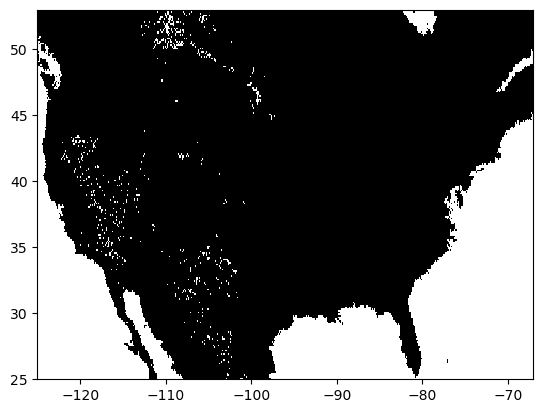

In [10]:
# ---- Visualize the flow map, using heatmap style ---- #

# load conus domain data
with nc.Dataset(new_domain_file) as ds_domain:
    lat_array = ds_domain.variables['lat'][:].data
    lon_array = ds_domain.variables['lon'][:].data
    flow_dir_array = ds_domain.variables['flow_dir'][:, :].data

# create a boolean array to indicate whether a cell is a along the flow path
flow_path_array = np.isin(flow_dir_array, [1, 2, 4, 8, 16, 32, 64, 128])

# generate a meshgrid for the latitude and longitude
lon_grid, lat_grid = np.meshgrid(lon_array, lat_array)

# Plot
fig, ax = plt.subplots()
ax.pcolormesh(lon_grid, lat_grid, flow_path_array, cmap='binary')

plt.show()

## Selected River Basins

In [11]:
from shapely.geometry import Point

def get_grids_in_hu(lon_array, lat_array, gdf_huc):
    """
    Get grids (lon-lat) within the target HU
    
    gdf_huc: geodataframe of the target HU
    
    """
    
    # create lon-lat pairs from global vars: lon_array and lat_array
    lon_lat_all = [[Point(lon, lat), i, j] for i, lon in enumerate(lon_array) for j, lat in enumerate(lat_array)]    # [Point(lon, lat), i-lon index, j-lat index]
    
    # index the wanted hu from the gdf
    huc_geo = gdf_huc['geometry'].values   # the polygon for this huc
        
    # find (lon, lat) pairs within the area
    lon_lat_sub = [i for i in lon_lat_all if huc_geo.contains(i[0])[0]]

    # create point geodataframe for selected points and check
    d = {'lon index': [i[1] for i in lon_lat_sub], 'lat index': [i[2] for i in lon_lat_sub]}
    gdf_points = gpd.GeoDataFrame(d, 
                                  geometry=[i[0] for i in lon_lat_sub], crs='EPSG:4326')   # lon index, lat index, geometry
    
    result = {
        'grids_in_hu': gdf_points,    # gdf - lon index, lat index, geometry; the index represents index in .nc files
        'others': (lon_array, lat_array, gdf_huc)    # this is mainly for plot check
    }
    
    return(result)

def d8_to_uv(d8_value):
    """
    Convert the D8 flow direction value to u and v components.
    The values follow the pattern (1, 2, 4, 8, 16, 32, 64, 128),
    representing the following directions (assuming north is up):
    32  64 128
    16  x   1
    8   4   2

    :param d8_value: D8 flow direction value [int]
    """
    
    directions = {
        1: (1, 0),    # right (east)
        2: (1, -1),   # down-right (southeast)
        4: (0, -1),   # down (south)
        8: (-1, -1),  # down-left (southwest)
        16: (-1, 0),  # left (west)
        32: (-1, 1),  # up-left (northwest)
        64: (0, 1),   # up (north)
        128: (1, 1)   # up-right (northeast)
    }

    return directions.get(d8_value, (0, 0))


In [ ]:
# ---- Read files ---- #

huc4 = '1804'

nhd_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Drought_Cycle_Analysis/Data'
crs = 'EPSG:4326'
huc2_conus = [f'0{i}' if i<10 else f'{i}' for i in range(1, 19)]

# read HUCs
huc2 = huc4[0:2]
gdb_file = f'{nhd_data_dir}/Raw/WBD/WBD_{huc2}_HU2_GDB.gdb'
gdf_huc2_all = gpd.read_file(gdb_file, layer='WBDHU2')
gdf_huc4_all = gpd.read_file(gdb_file, layer='WBDHU4')
gdf_huc6_all = gpd.read_file(gdb_file, layer='WBDHU6')
gdf_huc8_all = gpd.read_file(gdb_file, layer='WBDHU8')
gdf_huc10_all = gpd.read_file(gdb_file, layer='WBDHU10')

# set crs
gdf_huc2_all = gdf_huc2_all.set_crs(crs, inplace=False, allow_override=True)    # includes the huc2 region
gdf_huc4_all = gdf_huc4_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc4 subregions in this huc2 region
gdf_huc6_all = gdf_huc6_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc6 basins in this huc2 region
gdf_huc8_all = gdf_huc8_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc8 subbasins in this huc2 region
gdf_huc10_all = gdf_huc10_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc10 subbasins in this huc2 region

########## Prepare flow lines ##########

if huc2 == '03':    # multiple NHDP files for 03
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['N','S','W']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['N','S','W']]
elif huc2 == '10': 
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['U','L']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['U','L']]
else:
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDPlusAttributes']
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDSnapshot/Hydrography']

gdf_flow_list = []
for flow_attr_file, hydro_file in zip(flow_attr_file_list, hydro_file_list):
    gdf_fline_vaa = gpd.read_file(flow_attr_file, layer='PlusFlowlineVAA')
    gdf_fline = gpd.read_file(hydro_file, layer='NHDFlowline')

    # change COMID to ComID if the error exists
    if not 'ComID' in gdf_fline:
        gdf_fline.rename(columns={'COMID':'ComID'}, inplace=True)

    # change vaa file ComID to int
    to_int_var = ['ComID', 'StreamOrde', 'StreamCalc']
    gdf_fline_vaa[to_int_var] = gdf_fline_vaa[to_int_var].astype(int)

    # merge this two gdfs
    to_merge_vars = ['ComID', 'StreamOrde', 'StreamCalc', 'FromNode', 'ToNode']
    gdf_flow = gdf_fline.merge(gdf_fline_vaa[to_merge_vars], how='inner', on='ComID')
    
    gdf_flow_list.append(gdf_flow)

gdf_flow = pd.concat(gdf_flow_list)

# set crs
gdf_flow = gdf_flow.set_crs(crs, inplace=True, allow_override=True)

# subset to the target huc4
gdf_flow_huc4 = gdf_flow.sjoin(gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4], how='inner', predicate='intersects')

########## End Prepare flow lines ##########

# read conus domain
new_domain_file = f'{data_dir}/processed/LRR/input/conus_nldas_grid.nc'
with nc.Dataset(new_domain_file) as ds_domain:
    lat_array = ds_domain.variables['lat'][:].data
    lon_array = ds_domain.variables['lon'][:].data
    flow_dir_array = ds_domain.variables['flow_dir'][:, :].data
    grid_id_conus_array = ds_domain.variables['id'][:, :].data





In [ ]:
# ---- Visualize the flow map, using arrows ---- #

# Get the grids within the target HU
gdf_huc4 = gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4]
result = get_grids_in_hu(lon_array, lat_array, gdf_huc4)
gdf_grid_index_in_hu = result['grids_in_hu']
lon_index = gdf_grid_index_in_hu['lon index'].values    # contains duplicate values
lat_index = gdf_grid_index_in_hu['lat index'].values    # contains duplicate values

# Subset flow direction array to the HU
# technically, I didn't "subset", just set the flow direction values outside the HU to -9999
mask = np.ones_like(flow_dir_array, dtype=bool)
mask[lat_index, lon_index] = False
flow_dir_array[mask] = -9999
# subset the array
lat_index_unique = np.unique(lat_index)
lon_index_unique = np.unique(lon_index)
xx, yy = np.meshgrid(lat_index_unique, lon_index_unique, indexing='ij')
flow_dir_array_huc4 = flow_dir_array[xx, yy]    # get the square matrix of flow direction

# Generate a meshgrid for the latitude and longitude
lon_array_huc4 = np.unique(lon_array[lon_index])
lat_array_huc4 = np.unique(lat_array[lat_index])
lon_grid, lat_grid = np.meshgrid(lon_array_huc4, lat_array_huc4)

# Convert the flow direction values to u and v components
u = np.zeros_like(flow_dir_array_huc4, dtype=int)
v = np.zeros_like(flow_dir_array_huc4, dtype=int)
for i in range(flow_dir_array_huc4.shape[0]):
    for j in range(flow_dir_array_huc4.shape[1]):
        u[i, j], v[i, j] = d8_to_uv(flow_dir_array_huc4[i, j])


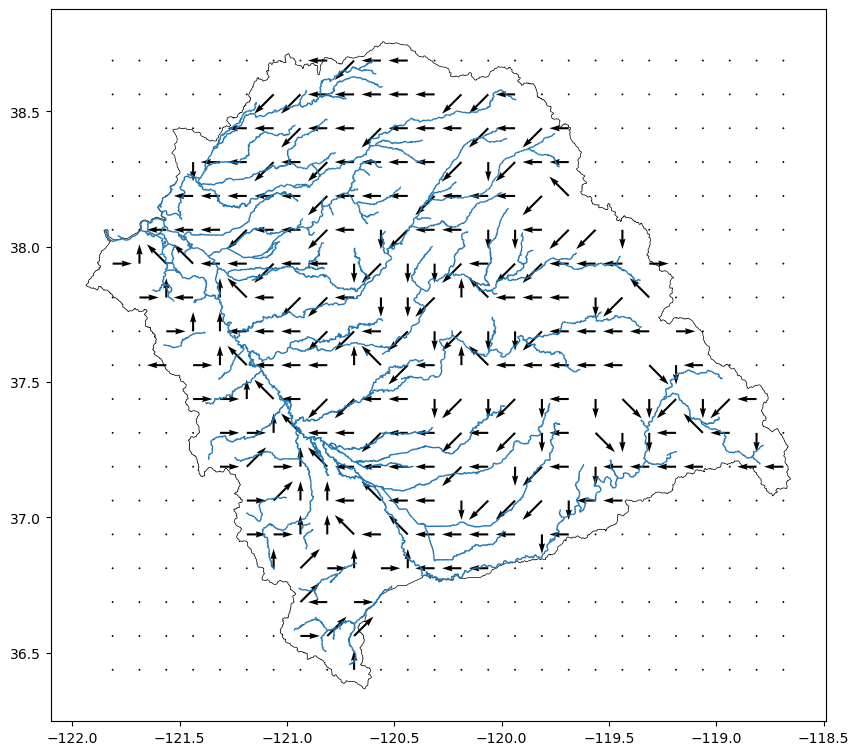

In [ ]:
# Plot the flow direction
fig, ax = plt.subplots(figsize=(10, 10))

# plot flow line
# specify to which stream order
max_order = gdf_flow_huc4['StreamOrde'].max()
min_order_to_keep = 4
gdf_flow_huc4.loc[gdf_flow_huc4['StreamOrde']>=min_order_to_keep].plot(ax=ax, linewidth=1)

ax.quiver(lon_grid, lat_grid, u, v, scale=40)

ax.set_aspect('equal')

gdf_huc4.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5)

plt.show()



# Create .nc for Reservoirs CONUS

In [ ]:
def get_nearest_grid(lat, lon, lat_array, lon_array):
    """
    Get the nearest grid cell index for a given lat-lon pair.
    
    lat: latitude of the reservoir
    lon: longitude of the reservoir
    lat_array: latitude array of the domain
    lon_array: longitude array of the domain
    
    """

    dist_min = 999999
    # get the index of the nearest grid cell
    # gosh, this is so slow...
    # maybe I should use geopandas distance or geopy distance for vectorization
    for i, grid_lat in enumerate(lat_array):
        for j, grid_lon in enumerate(lon_array):
            dist = geopy.distance.distance((lat, lon), (grid_lat, grid_lon))
            if dist < dist_min:
                dist_min = dist
                lat_index = i
                lon_index = j
    
    return((lat_index, lon_index))

# Read reservoir information
reservoir_file = f'{data_dir}/processed/reservoir_metadata.xlsx'
df_reservoir = pd.read_excel(reservoir_file, dtype={'huc4':str})

# Read conus domain
domain_file = f'{data_dir}/processed/LRR/input/conus_nldas_grid.nc'
with nc.Dataset(domain_file) as ds_domain:
    id_array = ds_domain.variables['id'][:, :].data
    lat_array = ds_domain.variables['lat'][:].data
    lon_array = ds_domain.variables['lon'][:].data

# Find the grid cell where the reservoir is located, i.e., nearest grid
reservoir_lat_on_id_array = np.zeros((df_reservoir.shape[0], 3), dtype=int)
for index, row in df_reservoir.iterrows():
    lat = row['lattitude']
    lon = row['longtitude']
    lat_index, lon_index = get_nearest_grid(lat, lon, lat_array, lon_array)

    reservoir_lat_on_id_array[index, 0] = row['ID']
    reservoir_lat_on_id_array[index, 1] = lat_index
    reservoir_lat_on_id_array[index, 2] = lon_index

# Create new nc to store the reservoir information & grid cell ID (to be continued)

In [ ]:
# Create new nc to store the reservoir information & grid cell ID (continued)

reservoir_nc = f'{data_dir}/processed/LRR/input/reservoirs.nc'

with nc.Dataset(reservoir_nc, 'w', format='NETCDF4') as ds_reservoir:
    # create dimensions
    ds_reservoir.createDimension('index', df_reservoir.shape[0])

    # create variables
    id = ds_reservoir.createVariable('gid', 'i4', ('index',))    # HydroShare ID: GRAND_ID + self-defined ID
    name = ds_reservoir.createVariable('name', 'S1', ('index',))    # dam name
    main_use = ds_reservoir.createVariable('main_use', 'S1', ('index',))    # main use of the reservoir
    grid_id = ds_reservoir.createVariable('grid_id', 'i4', ('index',))
    lat = ds_reservoir.createVariable('lat', 'f4', ('index',))
    lon = ds_reservoir.createVariable('lon', 'f4', ('index',))
    max_storage = ds_reservoir.createVariable('max_storage', 'f4', ('index',))

    # write data
    id[:] = reservoir_lat_on_id_array[:, 0]
    name[:] = df_reservoir['Dam name '].values
    main_use[:] = df_reservoir['MAIN_USE'].values
    grid_id[:] = id_array[reservoir_lat_on_id_array[:, 1], reservoir_lat_on_id_array[:, 2]]
    lat[:] = df_reservoir['lattitude'].values
    lon[:] = df_reservoir['longtitude'].values
    max_storage[:] = df_reservoir['Maximum Storage'].values

    # set attributes
    id.long_name = 'Reservoir ID in the GRDOM HydroShare dataset'
    name.long_name = 'Dam name'
    main_use.long_name = 'Main use of the reservoir'
    grid_id.long_name = 'ID of the grid cell where the reservoir is located'
    lat.long_name = 'Latitude of the reservoir'
    lon.long_name = 'Longitude of the reservoir'
    max_storage.long_name = 'Maximum storage of the reservoir (in acre-feet)'
    max_storage.units = 'acre-feet'


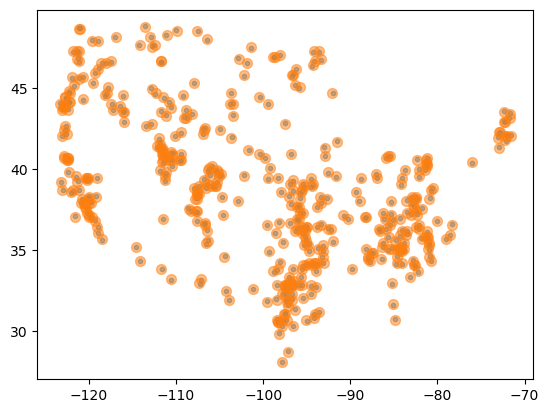

In [ ]:
# ---- Visualize the reservoirs & grid match on the domain map ---- #

conus_domain_nc = f'{data_dir}/processed/LRR/input/conus_nldas_grid.nc'
reservoir_nc = f'{data_dir}/processed/LRR/input/reservoirs.nc'

with nc.Dataset(reservoir_nc) as ds:
    lat = ds.variables['lat'][:].data
    lon = ds.variables['lon'][:].data
    grid_id_res = ds.variables['grid_id'][:].data

with nc.Dataset(conus_domain_nc) as ds:
    lat_domain = ds.variables['lat'][:].data
    lon_domain = ds.variables['lon'][:].data
    grid_id_domain = ds.variables['id'][:, :].data

# For each item in grid_id_res, find the corresponding index in grid_id_domain
grid_id_domain_lat_index = np.zeros_like(grid_id_res, dtype=int)
grid_id_domain_lon_index = np.zeros_like(grid_id_res, dtype=int)
for i, grid_id in enumerate(grid_id_res):
    grid_id_domain_lat_index[i] = np.argwhere(grid_id_domain==grid_id)[0][0]
    grid_id_domain_lon_index[i] = np.argwhere(grid_id_domain==grid_id)[0][1]
    
# Plot
fig, ax = plt.subplots()
ax.scatter(lon, lat, s=10, alpha=0.5, label='Reservoirs')
ax.scatter(lon_domain[grid_id_domain_lon_index], lat_domain[grid_id_domain_lat_index], s=50, alpha=0.5, label='Grid cells')

plt.show()

In [ ]:
# For each item in grid_id_res, find the corresponding index in grid_id_domain
grid_id_domain_lat_index = np.zeros_like(grid_id_res, dtype=int)
grid_id_domain_lon_index = np.zeros_like(grid_id_res, dtype=int)
for i, grid_id in enumerate(grid_id_res):
    grid_id_domain_lat_index[i] = np.argwhere(grid_id_domain==grid_id)[0][0]
    grid_id_domain_lon_index[i] = np.argwhere(grid_id_domain==grid_id)[0][1]

# Create Water Demand for CONUS

In [10]:
# read NLDAS runoff data & see its format

nldas_nc = f'{data_dir}/processed/LRR/input/nldas_runoff.nc'

ds_nldas = xr.load_dataset(nldas_nc)

In [45]:
ds_nldas

<xarray.Dataset>
Dimensions:  (time: 14610, lat: 224, lon: 464)
Coordinates:
  * time     (time) object '1980-01-01' '1980-01-02' ... '2019-12-31'
  * lat      (lat) float32 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float32 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
Data variables:
    Qs       (time, lat, lon) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    Qsb      (time, lat, lon) float64 nan nan nan nan ... 0.2839 0.2852 0.2849

In [38]:
# ---- Process global demand data from GCAM ---- #
# ---- Crop data ---- #

def pop_2010_to_1990(df):
    """
    Populate 2010 profile to 1990-2009
        In reality, I pop to 1988, since the simulation needs 2 years of spin-up time.
    """

    # Create a list of new column names from 199001 to 200912
    new_columns = [f"{year}{month:02d}" for year in range(1988, 2010) for month in range(1, 13)]

    # Extract the 2010 data for mapping
    df_2010 = df[[f"2010{month:02d}" for month in range(1, 13)]]

    # Initialize a dictionary to hold new column data
    new_columns_dict = {}

    # Populate the dictionary with new columns and their corresponding 2010 values
    for new_column in new_columns:
        month = int(new_column[-2:])  # Extract the month part
        corresponding_2010_column = f"2010{month:02d}"
        new_columns_dict[new_column] = df[corresponding_2010_column].values

    # Create a DataFrame from the dictionary
    new_columns_df = pd.DataFrame(new_columns_dict)

    # Concatenate this new DataFrame with the original one
    # First, select the non-monthly columns from the original DataFrame
    non_monthly_cols = df[['Grid_ID', 'lon', 'lat', 'ilon', 'ilat']]

    # Then concatenate the non-monthly columns, new monthly columns, and original monthly columns
    concatenated_df = pd.concat([non_monthly_cols, new_columns_df, df.drop(non_monthly_cols.columns, axis=1)], axis=1)

    return(concatenated_df)

def csv2ds(df):
    """Convert the GCAM csv file to an xarray Dataset"""

    # Parsing the date columns
    date_columns = [col for col in df.columns if col.isdigit()]

    # Melt the DataFrame
    df_melted = df.melt(id_vars=['lon', 'lat'], value_vars=date_columns, var_name='time', value_name=var_name)
    df_melted['time'] = pd.to_datetime(df_melted['time'], format='%Y%m')
    # sort by lon and lat
    df_melted.sort_values(by=['lon', 'lat', 'time'], inplace=True)

    # set index
    df_melted.set_index(['lon', 'lat', 'time'], inplace=True, drop=True)

    # create a xarray Dataset from df_melted
    # Please NOTE: there are many NaNs in the dataset, because the xarray Dataset creates a value for every possible combination of lon, lat, and time, 
    # even if the value does not exist in the original dataset.
    ds = xr.Dataset.from_dataframe(df_melted)

    return(ds)
    

dir_path = f'{data_dir}/raw/GCAM_demand_data/ssp1_rcp45_gfdl_consumption_crops_monthly_cropped'
var_name_pos = 2
# dir_path = f'{data_dir}/raw/GCAM_demand_data/ssp1_rcp45_gfdl_consumption_sectors_monthly_cropped'
# var_name_pos = 0

file_name_list = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# Process for the 1st file
file_name = file_name_list[0]
file_path = f'{dir_path}/{file_name}'
var_name = file_name.split('_')[var_name_pos]
print(var_name)
# read data
df = pd.read_csv(file_path)
# populate 2010 profile to 1990-2009
df_popped = pop_2010_to_1990(df)
ds = csv2ds(df_popped)

# Process for the rest of the files
for file_name in file_name_list[1:]:
    file_path = f'{dir_path}/{file_name}'
    var_name = file_name.split('_')[var_name_pos]
    print(var_name)
    # read data
    df = pd.read_csv(file_path)
    # populate 2010 profile to 1990-2009
    df_popped = pop_2010_to_1990(df)
    ds_new = csv2ds(df_popped)
    # merge with the previous ds
    ds = xr.merge([ds, ds_new])






FodderGrass
Rice
biomass
PalmFruit
Root
OilCrop
MiscCrop
OtherGrain
FiberCrop
FodderHerb
Wheat
Corn
SugarCrop


In [39]:
# ---- Upscale to the CONUS grid ---- #

# Read conus domain
conus_domain_nc = f'{data_dir}/processed/LRR/input/conus_nldas_grid.nc'
ds_conus = xr.load_dataset(conus_domain_nc)

# Upscale to the conus grid
# 1. crop the global data to the conus domain
ds_conus_crop = ds.sel(lon=slice(ds_conus['lon'].min(), ds_conus['lon'].max()), lat=slice(ds_conus['lat'].min(), ds_conus['lat'].max()))

# 2. upscale to the conus grid
# before that, we need to convert the km3 per grid to depth per grid
ds_conus_crop_depth = ds_conus_crop.copy()
for var in ds_conus_crop_depth.data_vars:
    ds_conus_crop_depth[var] = ds_conus_crop_depth[var] / (55*55) * 10e6    # km3 -> mm
    ds_conus_crop_depth[var].attrs['units'] = 'mm/month'

ds_conus_upscale = ds_conus_crop_depth.interp(lat=ds_conus['lat'], lon=ds_conus['lon'], method='nearest')



In [40]:
# ---- save to netcdf ---- #
# ds_conus_upscale.to_netcdf(f'{data_dir}/processed/GCAM_demand_data/crop_conus.nc')
# ds_conus_upscale.to_netcdf(f'{data_dir}/processed/GCAM_demand_data/sector_conus.nc')

In [41]:
# ---- Add all the sectors together ---- #

ds_crop_conus = xr.load_dataset(f'{data_dir}/processed/GCAM_demand_data/crop_conus.nc')
ds_sector_conus = xr.load_dataset(f'{data_dir}/processed/GCAM_demand_data/sector_conus.nc')

# Add all the sectors together
# create a new dataset with the same dimensions as ds_crop_conus
ds_all_conus = xr.Dataset(
    data_vars={'total_consumption': (['lon', 'lat', 'time'], np.zeros_like(ds_crop_conus['Wheat']))},
    coords={'lat': ds_crop_conus['lat'], 'lon': ds_crop_conus['lon'], 'time': ds_crop_conus['time']})

# add all the sectors together: crops
for var in ds_crop_conus.data_vars:
    ds_all_conus['total_consumption'] += ds_crop_conus[var]

# add all the sectors together: other sectors
for var in ds_sector_conus.data_vars:
    ds_all_conus['total_consumption'] += ds_sector_conus[var]

# fill all the NaNs with 0
ds_all_conus_filled = ds_all_conus.fillna(0)

# transpose to reorder the dimensions
ds_all_conus_filled = ds_all_conus_filled.transpose('time', 'lat', 'lon')

# Interpolate the data to daily scale
# assume constant consumption within a month
start_date = ds_all_conus_filled['time'].min().values
end_date = ds_all_conus_filled['time'].max().values
daily_time = pd.date_range(start=start_date, end=end_date, freq='D')

ds_all_conus_daily = ds_all_conus_filled.reindex(time=daily_time, method='ffill')

# divide by 30 to get mm/day
ds_all_conus_daily = ds_all_conus_daily / 30

# add units
ds_all_conus_daily['total_consumption'].attrs['units'] = 'mm/day'

# change ds_all_conus_daily time to string yyyy-mm-dd
ds_all_conus_daily['time'] = ds_all_conus_daily['time'].dt.strftime('%Y-%m-%d')




In [43]:
# save to netcdf
# ds_all_conus_daily.to_netcdf(f'{data_dir}/processed/LRR/input/total_consumption_conus.nc')

: 

In [31]:
gcam_demand_nc_path = f'{data_dir}/processed/LRR/input/total_consumption_conus.nc'
with nc.Dataset(gcam_demand_nc_path, 'r') as ds:
    time = ds.variables['time'][:]

In [32]:
time

array(['1990-01-01', '1990-01-02', '1990-01-03', ..., '2024-11-29',
       '2024-11-30', '2024-12-01'], dtype=object)

In [5]:
ds_all_conus_daily

<xarray.Dataset>
Dimensions:            (lat: 224, lon: 464, time: 12754)
Coordinates:
  * lat                (lat) float32 25.06 25.19 25.31 ... 52.69 52.81 52.94
  * lon                (lon) float32 -124.9 -124.8 -124.7 ... -67.19 -67.06
  * time               (time) datetime64[ns] 1990-01-01 ... 2024-12-01
Data variables:
    total_consumption  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0